# Midterm: Probabilistic Roadmaps (30 Pts)

For the midterm, you will implement a variant of the RRT algorithm known as the Probabilistic Roadmap (PRM) algorithm. The difference between PRM and RRT is that PRM builds a graph that tries to capture the connectivity between all of its nodes. This is less efficient, but more fully approximates the connectivity of the configuration space. Moreover, once the PRM is built, it provides a means to get between any two configurations, assuming the PRM sampled enough points. This can be done using any graph search algorithm of your choosing.

First, we will load in the functions from the RRT lab that we will reuse.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

%matplotlib notebook

def conf_free(q: np.ndarray, obstacles: List[Tuple[np.ndarray, float]]) -> bool:
    """
    Check if a configuration is in the free space.
    
    This function checks if the configuration q lies outside of all the obstacles in the connfiguration space.
    
    @param q: An np.ndarray of shape (2,) representing a robot configuration.
    @param obstacles: A list of obstacles. Each obstacle is a tuple of the form (center, radius) representing a circle.
    @return: True if the configuration is in the free space, i.e. it lies outside of all the circles in `obstacles`. 
             Otherwise return False.
    """
    free = True
    
    for obs in obstacles:
        free = free and np.linalg.norm(q - obs[0]) > obs[1]
        
    return free

def edge_free(edge: Tuple[np.ndarray, np.ndarray], obstacles: List[Tuple[np.ndarray, float]]) -> bool:

    """

    Check if a graph edge is in the free space.

    This function checks if a graph edge, i.e. a line segment specified as two end points, lies entirely outside of
    every obstacle in the configuration space.
    
    @param edge: A tuple containing the two segment endpoints.
    @param obstacles: A list of obstacles as described in `config_free`.
    
    @return: True if the edge is in the free space, i.e. it lies entirely outside of all the circles in `obstacles`.
             Otherwise return False.
    """

    free = True
   
    for o in obstacles:
        n = (edge[1] - edge[0]) / np.linalg.norm(edge[1] - edge[0])
        p = edge[0]
        q = o[0]
       
        t = (n[0] * q[0] + n[1] * q[1] - n[0] * p[0] - n[1] * p[1]) / (n[0] ** 2 + n[1] ** 2)
       
        if t < 0:
            test_point = p
        elif t > np.linalg.norm(edge[1] - edge[0]):
            test_point = edge[1]
        else:
            test_point = p + t * n
       
        dist = np.linalg.norm(test_point - q)
        free = free and dist > o[1]

   
    return free

def random_conf(width: float, height: float) -> np.ndarray:
    """
    Sample a random configuration from the configuration space.
    
    This function draws a uniformly random configuration from the configuration space rectangle. The configuration 
    does not necessarily have to reside in the free space.
    
    @param width: The configuration space width.
    @param height: The configuration space height.
    @return: A random configuration uniformily distributed across the configuration space.
    """
    return np.random.rand(2) * np.array([width, height])

def random_free_conf(width: float, height: float, obstacles: List[Tuple[np.ndarray, float]]) -> np.ndarray:
    """
    Sample a random configuration from the free space.
    
    This function draws a uniformly random configuration from the configuration space
    rectangle that lies in the free space.
    
    @param width: The configuration space width.
    @param height: The configuration space height.
    @param obstacles: The list of configuration space obstacles as defined in `edge_free` and `conf_free`.
    @return: A random configuration uniformily distributed across the configuration space.
    """
    while True:
        conf = random_conf(width, height)
        
        if conf_free(conf, obstacles):
            return conf
        
def backtrack(index: int, parents: np.ndarray) -> List[int]:
    """
    Find the sequence of nodes from the origin of the graph to an index.
    
    This function returns a List of vertex indices going from the origin vertex to the vertex `index`.
    
    @param index: The vertex to find the path through the tree to.
    @param parents: The array of vertex parents as specified in the `rrt` function.
    
    @return: The list of vertex indicies such that specifies a path through the graph to `index`.
    """
    
    i = index
    vert_idx = []
    
    while i >= 0:
        vert_idx.insert(0, i)
        i = parents[i]
    
    return vert_idx

## The PRM Algorithm (15 Pts)
Now, the PRM algorithm proceeds as follows:

1. Sample $N$ configurations from the free space and add them to $\mathcal{V}$.

2. For each $q \in \mathcal{V}$:

    a. Find the $K$ closest members of $\mathcal{V}$ to $q$. Call this $\mathcal{V}_{near}$. Do not include $q$ itself in $\mathcal{V}_{near}$ as this will simplify later searches.
    
    b. For each $q' \in \mathcal{V}_{near}$, if $(q, q')$ is a collision free edge, add $(q, q')$ to $\mathcal{E}$.
 
3. Return $(\mathcal{V}, \mathcal{E})$.
    
For our purposes, we will measure the distance between configurations using the Euclidean distance
$$ \mathrm{dist}(q, q') = \sqrt{(q_1 - q'_1)^2 + (q_2 - q'_2)^2} $$
and say an edge is collision free if the line segment between its vertices lies entirely within the free space.

Implement this algorithm below.

In [3]:
def prm(width: float, height: float, obstacles: List[Tuple[np.ndarray, float]], 
        num_closest: int=8, num_vertices: int=50) -> List[Tuple[int, int]]:
    """
    Creates a probabilistic roadmap.
    
    @param width: The width of the configuration space.
    @param height: The height of the configuration space.
    @param obstacles: A list of circular obstacles.
    @param num_closest: The number of close vertices to connect to each vertex.
    @param num_vertices: The number of vertices to add to the PRM graph.
    
    @returns: A pair (vertices, edges) where vertices is an array of size num_vertices-by-2
              with each vertex as a row and edges is a list of tuples (i, j) signifying that
              the vertex in row i is connected to the vertex in row j.
    """
    vertices = np.zeros((num_vertices, 2))
    edges = []
    
    # Your code goes here
    for i in range(num_vertices):
        q = random_free_conf(width, height, obstacles)
        vertices[i, :] = q
    

    for i in range(num_vertices):
        dists = []
        start = vertices[i, :]
        for j in range(num_vertices):
            if i == j:
                continue

            end = vertices[j, :]
            dists.append((j, np.linalg.norm(start - end)))
        
        sort_dists = sorted(dists, key = lambda x: x[1])

        for j in range(num_closest):
            v = sort_dists[j][0]
            end = vertices[v, :]

            if edge_free((start, end), obstacles):
                edges.append((i, v))


    return vertices, edges

## Graph Search (15 Pts)

Next, we need a way to actually find a path through the graph between two locations of interest. In the next cell, implement breadth-first search.

In [4]:
def bfs(start_idx: int, goal_idx: int, num_vertices: int, edges: List[Tuple[int, int]]):
    """
    Breadth-First Search
    
    @param start_idx: The index of the vertex to start searching from
    @param goal_idx: The index we are searching for.
    @param num_vertices: The number of vertices in the graph (note you don't need the actual vertex values)
    @param edges: A list of tuples (i, j) signifying an edge in the graph between vertices i, j.
    
    @return: A list of parent indices. That is, if the search reaches node j from node i, then parents[j] == i.
             If no parent exists (e.g. for the first vertex or an unsearched vertex), set its parent to -1.
    """

    parents = [-1 for i in range(num_vertices)]

    q = [start_idx]
    num_iters = 0
    while len(q) > 0:
        #print(q)
        curr = q.pop(0)
        # print(curr)
        num_iters += 1

        if curr == goal_idx:
            break

        for e in edges:
            if curr == e[0] and parents[e[1]] == -1:
                if e[1] == start_idx:
                    continue
                parents[e[1]] = e[0]
                q.append(e[1])
            elif curr == e[1] and parents[e[0]] == -1:
                if e[0] == start_idx:
                    continue
                parents[e[0]] = e[1]
                q.append(e[0])

    return parents
            

## Testing it out!

Run the next two cells to call your algorithms and plot the result. It should produce a path from the bottom left corner to the top right corner.

In [8]:
width = 3
height = 4

obstacles = [(np.array([1, 1]), 0.25), (np.array([2, 2]), 0.25), (np.array([1, 3]), 0.3)]
goal = np.array([2.5, 3.5])

origin = np.array([0.1, 0.1])

vertices, edges = prm(width, height, obstacles)

# print(vertices, edges)
# print(len(vertices), len(edges))

start_idx = ((vertices - origin.reshape((1, 2))) ** 2).sum(axis=1).argmin()
goal_idx = ((vertices - goal.reshape((1, 2))) ** 2).sum(axis=1).argmin()

# print(start_idx, goal_idx)

parents = bfs(start_idx, goal_idx, vertices.shape[0], edges)

# print(parents)

if parents is not None:
    print('Path found!')
    path = backtrack(goal_idx, parents)
else:
    print('No path found!')





Path found!


In [9]:
%matplotlib inline

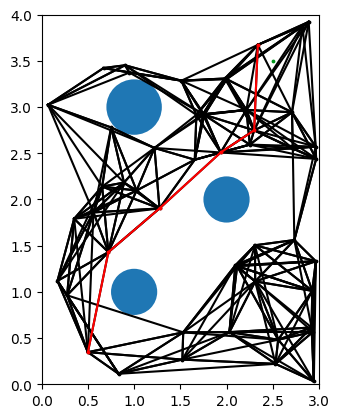

In [10]:
fig, ax = plt.subplots()

ax.set_xlim([0, width])
ax.set_ylim([0, height])
ax.set_aspect('equal')

for edge in edges:
    i, j = edge
    plt.plot([vertices[i, 0], vertices[j, 0]], 
             [vertices[i, 1], vertices[j, 1]], c='k')
    
for i in path:
    if parents[i] < 0:
        continue
    plt.plot([vertices[i, 0], vertices[parents[i], 0]], 
             [vertices[i, 1], vertices[parents[i], 1]], c='r')

for o in obstacles:
    ax.add_artist(plt.Circle(tuple(o[0]), o[1]))

plt.scatter([2.5], [3.5], zorder=3, c=np.array([[0.004, 0.596, 0.105]]), s=3)
plt.scatter(vertices[path, 0], vertices[path, 1], c=np.array([[1, 0, 0]]), s=3, zorder=2)
plt.scatter(vertices[1:, 0], vertices[1:, 1], c=np.array([[0, 0, 0]]), s=3)